In [58]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt

import jax
from jax import jit
from jax.lib import xla_bridge

print(f"Jax is using: {xla_bridge.get_backend().platform}")

import sys

sys.path.append("../")

Jax is using: gpu


# Simulate data


In [60]:
# define linear ultrasound transducer (P4-1)
nelements = 64
element_pitch = 2.95e-4  # distance between transducer elements
transducer_extent = (nelements - 1) * element_pitch  # length of the transducer [m]
transducer_frequency = 1e6  # frequency of the transducer [Hz]
transducer_magnitude = 1e6  # magnitude of the transducer [Pa]
print(f"Transducer extent: {transducer_extent:.3f} m")

Transducer extent: 0.019 m


In [61]:
# define spatial parameters
N = np.array([128, 128]).astype(int)  # grid size [grid points]
dx = np.array([element_pitch, element_pitch])  # grid spacing [m]
pml = np.array([20, 20])  # size of the perfectly matched layer [grid points]

# define transducer position in domain
transducer_depth = pml[1]  # depth of the transducer [grid points]
transducer_x_start = (
    N[0] // 2 - nelements // 2
)  # start index of the transducer in the x-direction [grid points]
element_positions = np.array(
    [
        np.linspace(transducer_x_start, transducer_x_start + nelements - 1, nelements),
        (N[1] - transducer_depth) * np.ones(nelements),
    ],
    dtype=int,
)

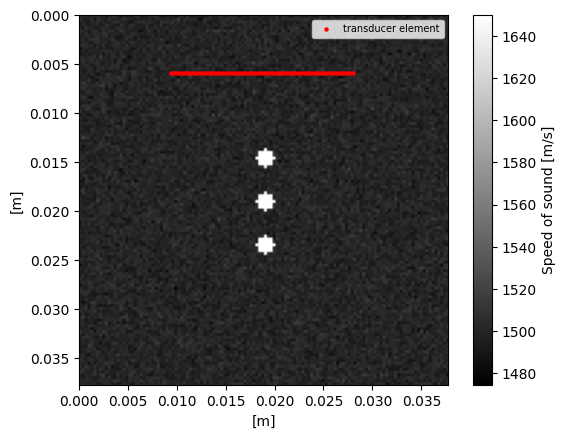

In [62]:
from jwave_utils import get_domain, get_point_medium, get_homogeneous_medium

# define jwave medium
medium_params = {
    "c0": 1500,  # speed of sound [m/s]
    "rho0": 1000,  # density [kg/m^3]
    "background_mean": 1,  # mean of the background noise
    "pml_size": pml[0],  # size of the perfectly matched layer [grid points]
}

domain = get_domain(N, dx)
speed_homogenous, density_homogenous = get_homogeneous_medium(
    domain, **medium_params, background_std=0, background_seed=29
)

scatterer_positions = np.array(
    [
        [domain.N[0] // 2, domain.N[1] // 2 + 15],
        [domain.N[0] // 2, domain.N[1] // 2],
        [domain.N[0] // 2, domain.N[1] // 2 - 15],
    ],
    dtype=int,
)
speed, density = get_point_medium(
    domain,
    scatterer_positions,
    **medium_params,
    background_std=0.004,
    scatterer_radius=3,
    scatterer_contrast=1.1,
    background_seed=28
)

ext = [0, N[0] * dx[0], N[1] * dx[1], 0]
plt.scatter(
    element_positions[0] * dx[0],
    N[1] * dx[1] - element_positions[1] * dx[1],
    c="r",
    marker="o",
    s=5,
    label="transducer element",
)
plt.imshow(np.rot90(speed), cmap="gray", extent=[0, N[1] * dx[1], 0, N[0] * dx[0]])
plt.colorbar(label="Speed of sound [m/s]")
plt.ylabel("[m]")
plt.xlabel("[m]")
plt.legend(prop={"size": 7})
plt.gca().invert_yaxis()
plt.show()

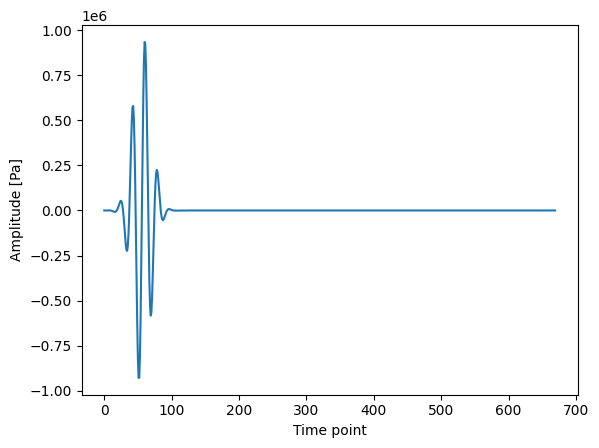

In [63]:
from jwave.geometry import TimeAxis
from jwave.geometry import Medium
from jwave_utils import get_plane_wave_excitation

signal_delay = 0
time_axis = TimeAxis.from_medium(
    Medium(domain, speed, density, pml_size=pml[0]), cfl=0.3
)
sources, signal, carrier_signal = get_plane_wave_excitation(
    domain,
    time_axis,
    transducer_magnitude,
    transducer_frequency,
    element_positions,
    signal_delay=signal_delay,
)

plt.plot(sources.signals[0])
plt.xlabel("Time point")
plt.ylabel("Amplitude [Pa]")
plt.show()

In [64]:
from jwave_utils import get_data

# simulate data using jwave
pressure, data = get_data(speed, density, domain, time_axis, sources, element_positions)
_, data_homogenous = get_data(
    speed_homogenous, density_homogenous, domain, time_axis, sources, element_positions
)

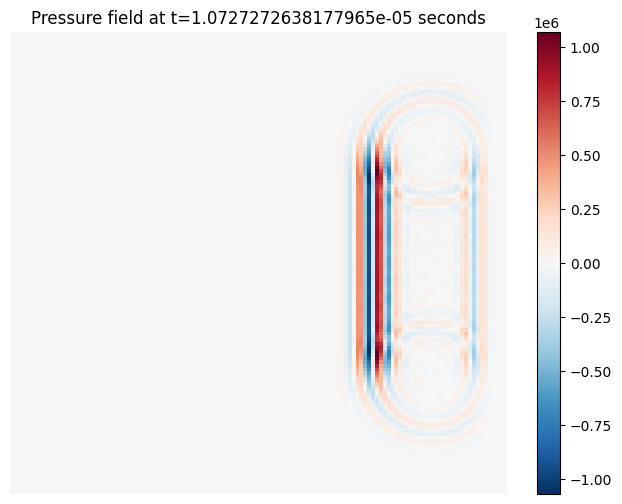

In [65]:
from jwave.utils import show_field

t_idx = 200
show_field(pressure[110])
plt.title(f"Pressure field at t={time_axis.to_array()[t_idx]} seconds")
plt.show()

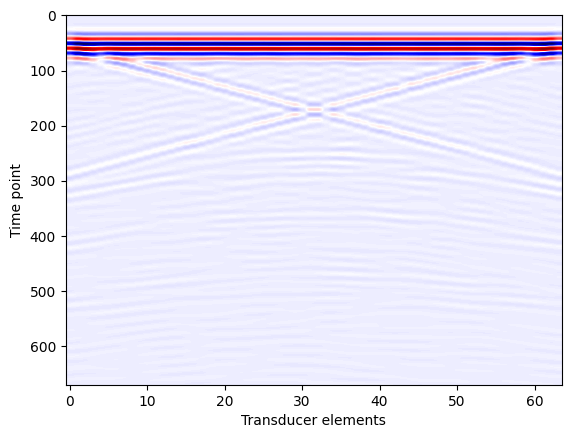

In [66]:
plt.imshow(data, aspect="auto", cmap="seismic")
plt.xlabel("Transducer elements")
plt.ylabel("Time point")
plt.show()

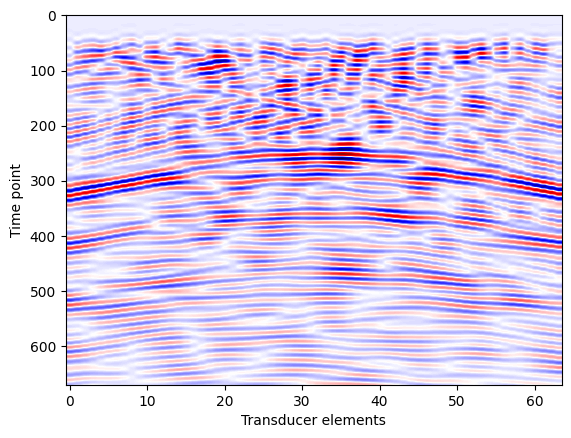

In [67]:
output_data = data - data_homogenous
plt.imshow(output_data, aspect="auto", cmap="seismic")
plt.xlabel("Transducer elements")
plt.ylabel("Time point")
plt.show()

# NTK Beamforming


In [69]:
from imaging.demodulate import demodulate_rf_to_iq

freq_sampling = 1 / time_axis.dt
iq_signals, freq_carrier = demodulate_rf_to_iq(
    output_data, freq_sampling, freq_carrier=transducer_frequency
)

In [71]:
N = domain.N[0]
Nz = N - transducer_depth
dx0 = domain.dx[0]

# Generate 1D arrays for x and z
x = np.linspace(-(N // 2) * dx0, (N // 2) * dx0, N)
z = np.linspace(0, Nz * dx0, Nz)

# Create 2D meshgrid for x and z
X, Z = np.meshgrid(x, z)

In [72]:
from imaging.beamform import beamform_delay_and_sum

beamformed_signal = beamform_delay_and_sum(
    iq_signals,
    X,
    Z,
    freq_sampling,
    freq_carrier,
    pitch=dx0,
    tx_delays=np.zeros(nelements),
)

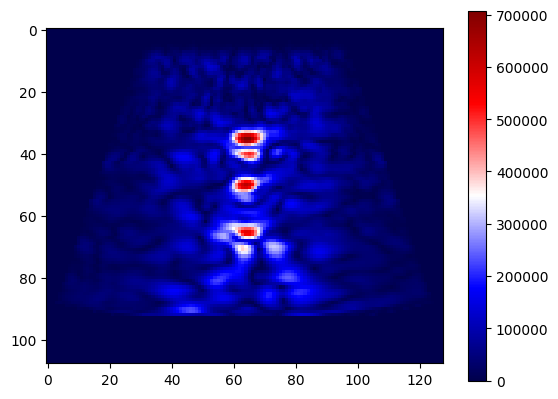

In [73]:
plt.imshow(np.abs(beamformed_signal), cmap="seismic")
plt.colorbar()
plt.show()